In [1]:
!pip install grad-cam


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 49.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=44284 sha256=eddaea6353a3ae9f3b485ea70b295d41c3a74375dac9ee7d9cda09cd0f190e58
  Stored in directory: /root/.cache/pip/wheels/fb/3b/09/2afc520f3d69bc26ae6bd87416759c820a3f7d05c1a077bbf6
Successfully built grad-cam


---


**Han Lab 6.5940 course assignment**:

We adopt the exact VGG-11 configuration from the Han Lab 6.5940 course assignment: 8 conv layers with BatchNorm and ReLU, following the channel progression [64, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'], ending with global average pooling (mean([2,3])) and a single linear classifier (512 → 10).

from their setup:
dense model has accuracy=92.95%
dense model has size=35.20 MiB
number of params: 9228362

Also the dataset being used for part 1 according to lecture slide;
MIT
6.5940
: Lecture 04:
Pruning and Sparsity
Part II is **CIFAR-10**

I will try to rpelicate this

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import copy
import time
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from PIL import Image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# ============================================================================

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

class VGG11(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG11, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Linear(512 * 1 * 1, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# xxxxx

def train_model(model, trainloader, criterion, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        pbar = tqdm(trainloader, desc=f'Epoch {epoch+1}/{epochs}')

        for inputs, labels in pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            pbar.set_postfix({'loss': f'{running_loss/(pbar.n+1):.3f}',
                            'acc': f'{100*correct/total:.2f}%'})

def evaluate_model(model, testloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

def fine_tune_model(model, trainloader, testloader, epochs=5, lr=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
    train_model(model, trainloader, criterion, optimizer, epochs)
    return evaluate_model(model, testloader)

def get_model_size(model):
    param_size = sum(p.nelement() * p.element_size() for p in model.parameters())
    buffer_size = sum(b.nelement() * b.element_size() for b in model.buffers())
    return (param_size + buffer_size) / 1024**2

def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

def count_nonzero_parameters(model):
    return sum((p != 0).sum().item() for p in model.parameters())

def calculate_sparsity(model):
    total = count_parameters(model)
    nonzero = count_nonzero_parameters(model)
    return 1 - (nonzero / total)

def get_conv_layers(model):
    return [(name, module) for name, module in model.named_modules()
            if isinstance(module, nn.Conv2d)]

def get_fc_layers(model):
    return [(name, module) for name, module in model.named_modules()
            if isinstance(module, nn.Linear)]

def measure_inference_time(model, testloader, num_batches=50):
    model.eval()
    times = []
    with torch.no_grad():
        for i, (inputs, _) in enumerate(testloader):
            if i >= num_batches:
                break
            inputs = inputs.to(device)
            start = time.time()
            _ = model(inputs)
            if device.type == 'cuda':
                torch.cuda.synchronize()
            times.append(time.time() - start)
    return np.mean(times[5:]), np.std(times[5:]) 

def count_flops(model, input_size=(1, 3, 32, 32)):
    """Approximate FLOPs counting for Conv2d and Linear layers"""
    flops = 0
    input_tensor = torch.randn(*input_size).to(device)

    def conv_hook(module, input, output):
        nonlocal flops
        batch_size, in_channels, in_h, in_w = input[0].shape
        out_channels, out_h, out_w = output.shape[1:]
        kernel_ops = module.kernel_size[0] * module.kernel_size[1] * in_channels
        output_ops = out_channels * out_h * out_w
        flops += batch_size * kernel_ops * output_ops

    def linear_hook(module, input, output):
        nonlocal flops
        batch_size = input[0].shape[0]
        flops += batch_size * module.in_features * module.out_features

    hooks = []
    for module in model.modules():
        if isinstance(module, nn.Conv2d):
            hooks.append(module.register_forward_hook(conv_hook))
        elif isinstance(module, nn.Linear):
            hooks.append(module.register_forward_hook(linear_hook))

    model.eval()
    with torch.no_grad():
        model(input_tensor)

    for hook in hooks:
        hook.remove()

    return flops

# ############funcs for visualization########################

def plot_weight_distribution(model, title="Weight Distribution", save_path=None):
    weights = []
    for param in model.parameters():
        if param.requires_grad and len(param.shape) > 1:
            weights.extend(param.data.cpu().numpy().flatten())

    weights = np.array(weights)
    non_zero_weights = weights[weights != 0]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.hist(weights, bins=100, alpha=0.7, edgecolor='black')
    ax1.set_xlabel('Weight Value')
    ax1.set_ylabel('Frequency')
    ax1.set_title(f'{title} - All Weights')
    ax1.grid(True, alpha=0.3)
    zero_pct = (weights == 0).sum() / len(weights) * 100
    ax1.text(0.02, 0.98, f'Zeros: {zero_pct:.2f}%',
             transform=ax1.transAxes, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    if len(non_zero_weights) > 0:
        ax2.hist(non_zero_weights, bins=100, alpha=0.7, edgecolor='black', color='orange')
        ax2.set_xlabel('Weight Value')
        ax2.set_ylabel('Frequency')
        ax2.set_title(f'{title} - Non-Zero Weights Only')
        ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()

def plot_layer_sparsity(model, title="Layer-wise Sparsity"):
    layers_info = []
    for name, module in model.named_modules():
        if isinstance(module, (nn.Conv2d, nn.Linear)):
            total = module.weight.numel()
            nonzero = (module.weight != 0).sum().item()
            sparsity = 1 - (nonzero / total)
            layers_info.append((name, sparsity, total))

    names = [info[0] for info in layers_info]
    sparsities = [info[1] * 100 for info in layers_info]

    plt.figure(figsize=(14, 6))
    bars = plt.bar(range(len(names)), sparsities, alpha=0.7, edgecolor='black')
    plt.xlabel('Layer')
    plt.ylabel('Sparsity (%)')
    plt.title(title)
    plt.xticks(range(len(names)), names, rotation=45, ha='right')
    plt.grid(True, alpha=0.3, axis='y')
    plt.axhline(y=np.mean(sparsities), color='r', linestyle='--',
                label=f'Mean: {np.mean(sparsities):.2f}%')
    plt.legend()
    plt.tight_layout()
    plt.show()

# xxxxxxxxxxxxxxxxxxxxxxxxxxx

def unstructured_prune_layer(layer, sparsity_ratio):
    """Prune individual weights based on L2 magnitude"""
    if isinstance(layer, (nn.Conv2d, nn.Linear)):
        weight = layer.weight.data
        threshold = torch.quantile(torch.abs(weight), sparsity_ratio)
        mask = torch.abs(weight) > threshold
        layer.weight.data *= mask.float()

def apply_unstructured_pruning(model, sparsity_ratios):
    """Apply unstructured pruning with per-layer sparsity ratios"""
    pruned_model = copy.deepcopy(model)
    conv_layers = get_conv_layers(pruned_model)
    fc_layers = get_fc_layers(pruned_model)

    for idx, (name, layer) in enumerate(conv_layers):
        if idx < len(sparsity_ratios['conv']):
            unstructured_prune_layer(layer, sparsity_ratios['conv'][idx])

    for idx, (name, layer) in enumerate(fc_layers):
        if idx < len(sparsity_ratios['fc']):
            unstructured_prune_layer(layer, sparsity_ratios['fc'][idx])

    return pruned_model

def sensitivity_analysis_unstructured(model, testloader, sparsity_values=[0.0, 0.2, 0.4, 0.6, 0.8]):
    """Analyze per-layer sensitivity to pruning"""
    conv_layers = get_conv_layers(model)
    fc_layers = get_fc_layers(model)
    all_layers = conv_layers + fc_layers

    sensitivity_results = {}

    for layer_idx, (layer_name, layer) in enumerate(all_layers):
        print(f"Analyzing {layer_name}...")
        layer_sensitivities = []

        for sparsity in sparsity_values:
            temp_model = copy.deepcopy(model)
            for name, module in temp_model.named_modules():
                if name == layer_name:
                    unstructured_prune_layer(module, sparsity)
                    break

            accuracy = evaluate_model(temp_model, testloader)
            layer_sensitivities.append(accuracy)
            print(f"  Sparsity {sparsity:.1f}: Accuracy {accuracy:.2f}%")

        sensitivity_results[layer_name] = layer_sensitivities

    return sensitivity_results, sparsity_values

def plot_sensitivity_analysis(sensitivity_results, sparsity_vals, title="Sensitivity Analysis"):
    """Plot sensitivity curves for all layers"""
    plt.figure(figsize=(16, 10))

    for layer_name, accuracies in sensitivity_results.items():
        plt.plot(sparsity_vals, accuracies, marker='o', label=layer_name, linewidth=2)

    plt.xlabel('Sparsity Ratio', fontsize=12)
    plt.ylabel('Accuracy (%)', fontsize=12)
    plt.title(title, fontsize=14)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    layer_names = list(sensitivity_results.keys())
    acc_matrix = np.array([sensitivity_results[name] for name in layer_names])

    plt.figure(figsize=(12, 8))
    sns.heatmap(acc_matrix, xticklabels=[f'{s:.1f}' for s in sparsity_vals],
                yticklabels=layer_names, annot=True, fmt='.1f', cmap='RdYlGn',
                vmin=0, vmax=100, cbar_kws={'label': 'Accuracy (%)'})
    plt.xlabel('Sparsity Ratio')
    plt.ylabel('Layer')
    plt.title(f'{title} - Heatmap')
    plt.tight_layout()
    plt.show()

# TASK 2

def get_channel_importance(layer):

    if isinstance(layer, nn.Conv2d):

        importance = torch.norm(layer.weight.data, p=2, dim=(1, 2, 3))
    elif isinstance(layer, nn.Linear):

        importance = torch.norm(layer.weight.data, p=2, dim=1)
    else:
        raise ValueError("error")
    return importance

def structured_prune_conv_layer(model, layer_idx, sparsity_ratio, conv_layers):

    if layer_idx >= len(conv_layers):
        return

    current_layer_name, current_layer = conv_layers[layer_idx]

    importance = get_channel_importance(current_layer)
    num_channels = len(importance)
    num_to_keep = int(num_channels * (1 - sparsity_ratio))
    num_to_keep = max(num_to_keep, 1) 

    _, sorted_indices = torch.sort(importance, descending=True)
    keep_indices = sorted_indices[:num_to_keep]
    keep_indices, _ = torch.sort(keep_indices)

    current_layer.weight = nn.Parameter(current_layer.weight.data[keep_indices])
    current_layer.out_channels = num_to_keep

    if current_layer.bias is not None:
        current_layer.bias = nn.Parameter(current_layer.bias.data[keep_indices])

    for name, module in model.named_modules():
        if name == current_layer_name.replace('features.', 'features.', 1):
            # Find corresponding BatchNorm (next module)
            found_current = False
            for n2, m2 in model.named_modules():
                if found_current and isinstance(m2, nn.BatchNorm2d):
                    m2.weight = nn.Parameter(m2.weight.data[keep_indices])
                    m2.bias = nn.Parameter(m2.bias.data[keep_indices])
                    m2.running_mean = m2.running_mean[keep_indices]
                    m2.running_var = m2.running_var[keep_indices]
                    m2.num_features = num_to_keep
                    break
                if n2 == name:
                    found_current = True

    if layer_idx + 1 < len(conv_layers):
        next_layer_name, next_layer = conv_layers[layer_idx + 1]
        next_layer.weight = nn.Parameter(next_layer.weight.data[:, keep_indices])
        next_layer.in_channels = num_to_keep

def apply_structured_pruning(model, sparsity_ratios):

    pruned_model = copy.deepcopy(model)
    conv_layers = get_conv_layers(pruned_model)

    for idx in range(len(conv_layers) - 1): 
        if idx < len(sparsity_ratios['conv']):
            structured_prune_conv_layer(pruned_model, idx,
                                      sparsity_ratios['conv'][idx],
                                      get_conv_layers(pruned_model))

    last_conv_channels = conv_layers[-1][1].out_channels
    fc_layers = get_fc_layers(pruned_model)
    if fc_layers:
        first_fc = fc_layers[0][1]
        expected_features = last_conv_channels * 1 * 1
        if first_fc.in_features != expected_features:
            first_fc.weight = nn.Parameter(
                first_fc.weight.data[:, :expected_features]
            )
            first_fc.in_features = expected_features

    return pruned_model

def sensitivity_analysis_structured(model, testloader, sparsity_values=[0.0, 0.2, 0.4, 0.6, 0.8]):

    conv_layers = get_conv_layers(model)
    sensitivity_results = {}

    for layer_idx in range(len(conv_layers) - 1):
        layer_name = conv_layers[layer_idx][0]
        print(f"Analyzing {layer_name}...")
        layer_sensitivities = []

        for sparsity in sparsity_values:
            temp_model = copy.deepcopy(model)
            try:
                structured_prune_conv_layer(temp_model, layer_idx, sparsity,
                                          get_conv_layers(temp_model))
                accuracy = evaluate_model(temp_model, testloader)
            except Exception as e:
                print(f"  Error at sparsity {sparsity}: {e}")
                accuracy = 0.0

            layer_sensitivities.append(accuracy)
            print(f"  Sparsity {sparsity:.1f}: Accuracy {accuracy:.2f}%")

        sensitivity_results[layer_name] = layer_sensitivities

    return sensitivity_results, sparsity_values

# TASK 3
# --------------

def generate_gradcam_comparison(models, model_names, testloader, num_samples=5):

    dataiter = iter(testloader)
    images, labels = next(dataiter)
    images, labels = images[:num_samples], labels[:num_samples]

    fig, axes = plt.subplots(num_samples, len(models) + 1,
                            figsize=(4 * (len(models) + 1), 4 * num_samples))

    for sample_idx in range(num_samples):
        img = images[sample_idx:sample_idx+1].to(device)

        orig_img = images[sample_idx].cpu().numpy().transpose(1, 2, 0)
        orig_img = (orig_img - orig_img.min()) / (orig_img.max() - orig_img.min())
        axes[sample_idx, 0].imshow(orig_img)
        axes[sample_idx, 0].set_title(f'Original\nTrue: {classes[labels[sample_idx]]}')
        axes[sample_idx, 0].axis('off')

        for model_idx, (model, name) in enumerate(zip(models, model_names)):
            model.eval()

            with torch.no_grad():
                output = model(img)
                pred = output.argmax(dim=1).item()

            target_layers = [list(model.features.children())[-3]]  

            try:
                cam = GradCAM(model=model, target_layers=target_layers)
                targets = [ClassifierOutputTarget(pred)]
                grayscale_cam = cam(input_tensor=img, targets=targets)
                grayscale_cam = grayscale_cam[0, :]

                visualization = show_cam_on_image(orig_img, grayscale_cam, use_rgb=True)
                axes[sample_idx, model_idx + 1].imshow(visualization)
                axes[sample_idx, model_idx + 1].set_title(
                    f'{name}\nPred: {classes[pred]}'
                )
            except Exception as e:
                axes[sample_idx, model_idx + 1].text(0.5, 0.5, f'Error: {str(e)[:20]}',
                                                     ha='center', va='center')

            axes[sample_idx, model_idx + 1].axis('off')

    plt.tight_layout()
    plt.show()

def compare_models_comprehensive(models, model_names, testloader, num_batches=50):

    results = []

    for model, name in zip(models, model_names):
        print(f"\nEvaluating {name}...")

        accuracy = evaluate_model(model, testloader)

        total_params = count_parameters(model)
        nonzero_params = count_nonzero_parameters(model)
        sparsity = calculate_sparsity(model)
        model_size = get_model_size(model)

        inf_time, inf_std = measure_inference_time(model, testloader, num_batches)
        flops = count_flops(model)

        results.append({
            'Model': name,
            'Accuracy (%)': accuracy,
            'Total Params': total_params,
            'Non-zero Params': nonzero_params,
            'Sparsity (%)': sparsity * 100,
            'Size (MB)': model_size,
            'Inference Time (ms)': inf_time * 1000,
            'Inference Std (ms)': inf_std * 1000,
            'FLOPs': flops,
            'FLOPs (M)': flops / 1e6
        })

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    axes[0, 0].bar(model_names, [r['Accuracy (%)'] for r in results])
    axes[0, 0].set_ylabel('Accuracy (%)')
    axes[0, 0].set_title('Model Accuracy')
    axes[0, 0].tick_params(axis='x', rotation=45)

    axes[0, 1].bar(model_names, [r['Size (MB)'] for r in results])
    axes[0, 1].set_ylabel('Size (MB)')
    axes[0, 1].set_title('Model Size')
    axes[0, 1].tick_params(axis='x', rotation=45)

    inf_times = [r['Inference Time (ms)'] for r in results]
    inf_stds = [r['Inference Std (ms)'] for r in results]
    axes[0, 2].bar(model_names, inf_times, yerr=inf_stds, capsize=5)
    axes[0, 2].set_ylabel('Inference Time (ms)')
    axes[0, 2].set_title('Inference Time per Batch')
    axes[0, 2].tick_params(axis='x', rotation=45)

    axes[1, 0].bar(model_names, [r['Sparsity (%)'] for r in results])
    axes[1, 0].set_ylabel('Sparsity (%)')
    axes[1, 0].set_title('Model Sparsity')
    axes[1, 0].tick_params(axis='x', rotation=45)

    axes[1, 1].bar(model_names, [r['FLOPs (M)'] for r in results])
    axes[1, 1].set_ylabel('FLOPs (Millions)')
    axes[1, 1].set_title('Computational Cost')
    axes[1, 1].tick_params(axis='x', rotation=45)

    efficiency = [r['Accuracy (%)'] / r['Size (MB)'] for r in results]
    axes[1, 2].bar(model_names, efficiency)
    axes[1, 2].set_ylabel('Accuracy / Size')
    axes[1, 2].set_title('Model Efficiency')
    axes[1, 2].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

    return results

def accuracy_vs_sparsity_curve(model, trainloader, testloader,
                               sparsity_levels=[0.0, 0.2, 0.4, 0.6, 0.8],
                               pruning_type='unstructured'):

    accuracies_before = []
    accuracies_after = []
    actual_sparsities = []

    for sparsity in sparsity_levels:
        print(f"\nTesting sparsity level: {sparsity:.1f}")

        if pruning_type == 'unstructured':

            num_conv = len(get_conv_layers(model))
            num_fc = len(get_fc_layers(model))
            sparsity_config = {
                'conv': [sparsity] * num_conv,
                'fc': [sparsity] * num_fc
            }
            pruned = apply_unstructured_pruning(model, sparsity_config)
        else: 
            num_conv = len(get_conv_layers(model))
            sparsity_config = {
                'conv': [sparsity] * (num_conv - 1),
                'fc': [0.0] * 3
            }
            try:
                pruned = apply_structured_pruning(model, sparsity_config)
            except:
                print(f"Failed at sparsity {sparsity}")
                break

        actual_sparsity = calculate_sparsity(pruned)
        actual_sparsities.append(actual_sparsity * 100)

        acc_before = evaluate_model(pruned, testloader)
        accuracies_before.append(acc_before)
        print(f"  Accuracy before fine-tuning: {acc_before:.2f}%")

        acc_after = fine_tune_model(pruned, trainloader, testloader, epochs=3, lr=0.001)
        accuracies_after.append(acc_after)
        print(f"  Accuracy after fine-tuning: {acc_after:.2f}%")
        print(f"  Actual sparsity: {actual_sparsity*100:.2f}%")

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(np.array(sparsity_levels[:len(accuracies_before)])*100,
             accuracies_before, 'o-', label='Before Fine-tuning', linewidth=2)
    ax1.plot(np.array(sparsity_levels[:len(accuracies_after)])*100,
             accuracies_after, 's-', label='After Fine-tuning', linewidth=2)
    ax1.set_xlabel('Target Sparsity (%)', fontsize=12)
    ax1.set_ylabel('Accuracy (%)', fontsize=12)
    ax1.set_title(f'Accuracy vs Sparsity - {pruning_type.capitalize()} Pruning', fontsize=14)
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    ax2.plot(actual_sparsities, accuracies_before, 'o-',
             label='Before Fine-tuning', linewidth=2)
    ax2.plot(actual_sparsities, accuracies_after, 's-',
             label='After Fine-tuning', linewidth=2)
    ax2.set_xlabel('Actual Sparsity (%)', fontsize=12)
    ax2.set_ylabel('Accuracy (%)', fontsize=12)
    ax2.set_title(f'Accuracy vs Actual Sparsity - {pruning_type.capitalize()}', fontsize=14)
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return accuracies_before, accuracies_after, actual_sparsities


Using device: cuda


100%|██████████| 170M/170M [00:05<00:00, 29.7MB/s]


In [ ]:
print("TRAINING BASELINE VGG-11 MODEL")

model = VGG11().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

train_model(model, trainloader, criterion, optimizer, epochs=20)
# torch.save(model.state_dict(), 'vgg11_baseline.pth')

# model.load_state_dict(torch.load('vgg11_baseline.pth'))

baseline_accuracy = evaluate_model(model, testloader)
baseline_size = get_model_size(model)
baseline_params = count_parameters(model)

print(f"\nBaseline Model Metrics:")
print(f"  Accuracy: {baseline_accuracy:.2f}%")
print(f"  Size: {baseline_size:.2f} MB")
print(f"  Parameters: {baseline_params:,}")


TRAINING BASELINE VGG-11 MODEL


Epoch 20/20: 100%|██████████| 391/391 [00:21<00:00, 18.48it/s, loss=0.322, acc=89.15%]



Baseline Model Metrics:
  Accuracy: 85.09%
  Size: 37.24 MB
  Parameters: 9,756,426


In [5]:
torch.save(model.state_dict(), 'vgg11_baseline.pth')

TASK 1: UNSTRUCTURED PRUNING

--- Part 1a: Weight Distribution Visualization ---


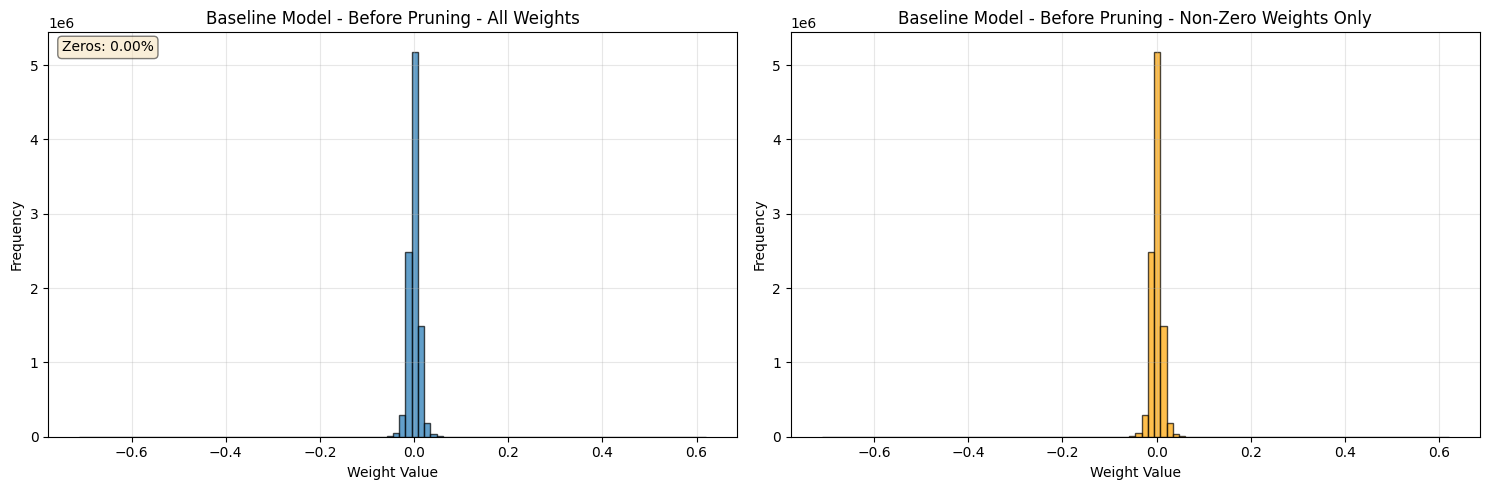


--- Part 1b: Sensitivity Analysis ---
Analyzing features.0...
  Sparsity 0.0: Accuracy 85.09%
  Sparsity 0.2: Accuracy 84.98%
  Sparsity 0.4: Accuracy 82.93%
  Sparsity 0.6: Accuracy 71.70%
  Sparsity 0.8: Accuracy 36.45%
Analyzing features.4...
  Sparsity 0.0: Accuracy 85.09%
  Sparsity 0.2: Accuracy 85.11%
  Sparsity 0.4: Accuracy 84.69%
  Sparsity 0.6: Accuracy 85.22%
  Sparsity 0.8: Accuracy 81.21%
Analyzing features.8...
  Sparsity 0.0: Accuracy 85.09%
  Sparsity 0.2: Accuracy 85.05%
  Sparsity 0.4: Accuracy 84.69%
  Sparsity 0.6: Accuracy 83.97%
  Sparsity 0.8: Accuracy 75.45%
Analyzing features.11...
  Sparsity 0.0: Accuracy 85.09%
  Sparsity 0.2: Accuracy 84.97%
  Sparsity 0.4: Accuracy 84.67%
  Sparsity 0.6: Accuracy 83.63%
  Sparsity 0.8: Accuracy 77.67%
Analyzing features.15...
  Sparsity 0.0: Accuracy 85.09%
  Sparsity 0.2: Accuracy 85.06%
  Sparsity 0.4: Accuracy 85.01%
  Sparsity 0.6: Accuracy 85.00%
  Sparsity 0.8: Accuracy 82.35%
Analyzing features.18...
  Sparsity 0.0

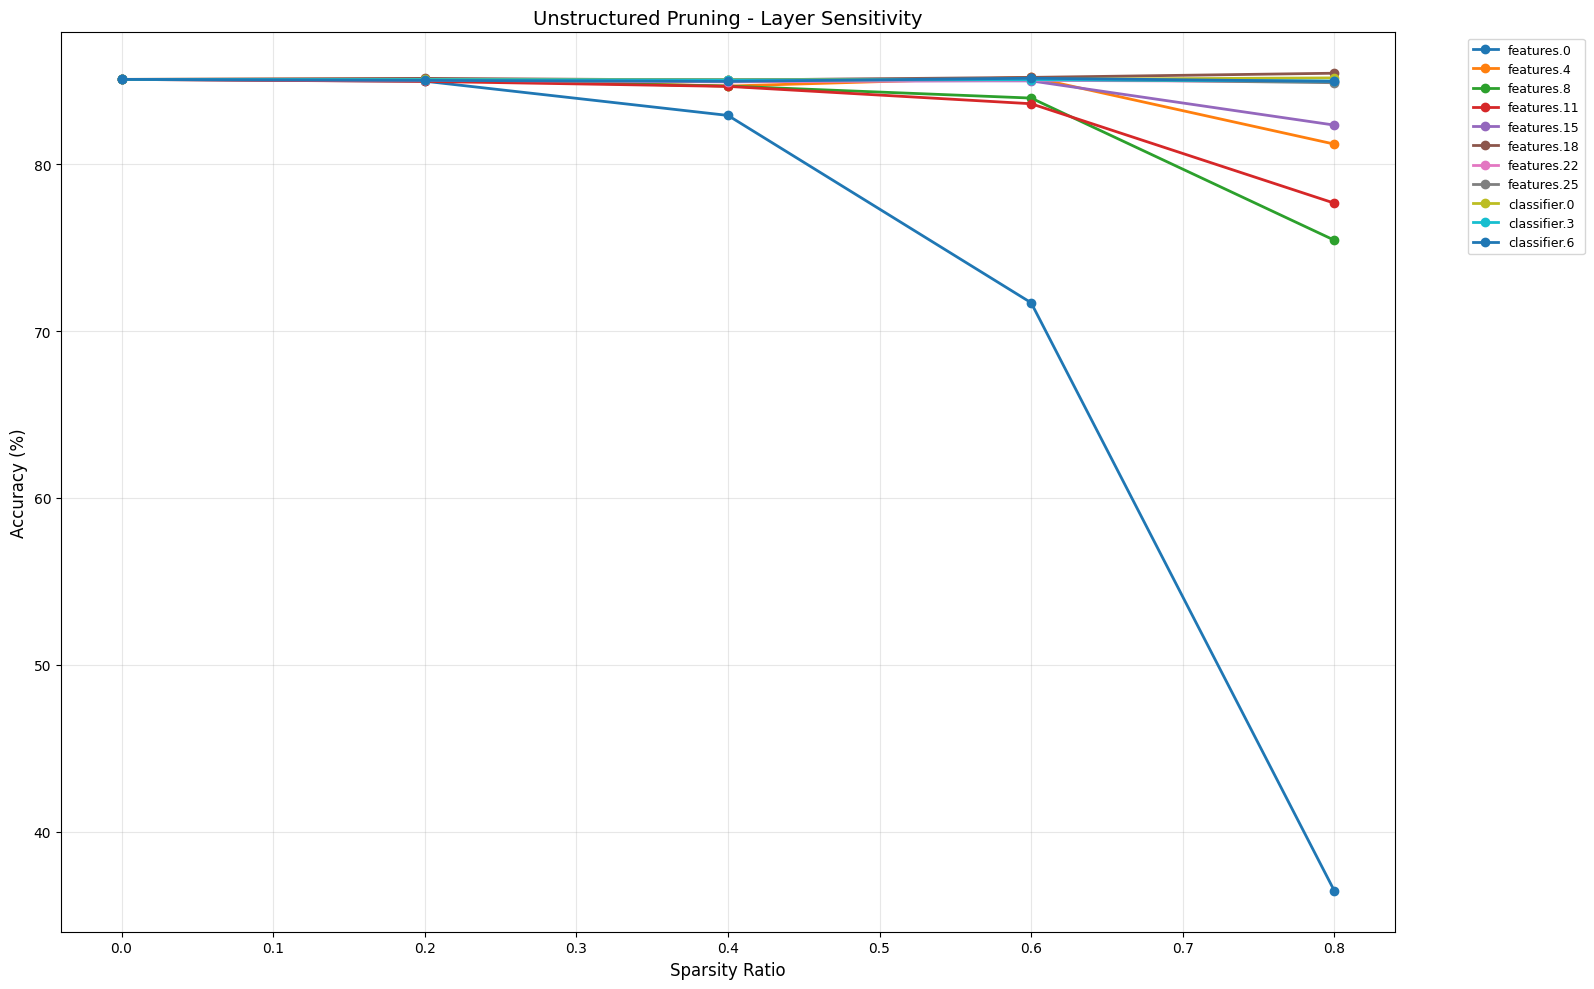

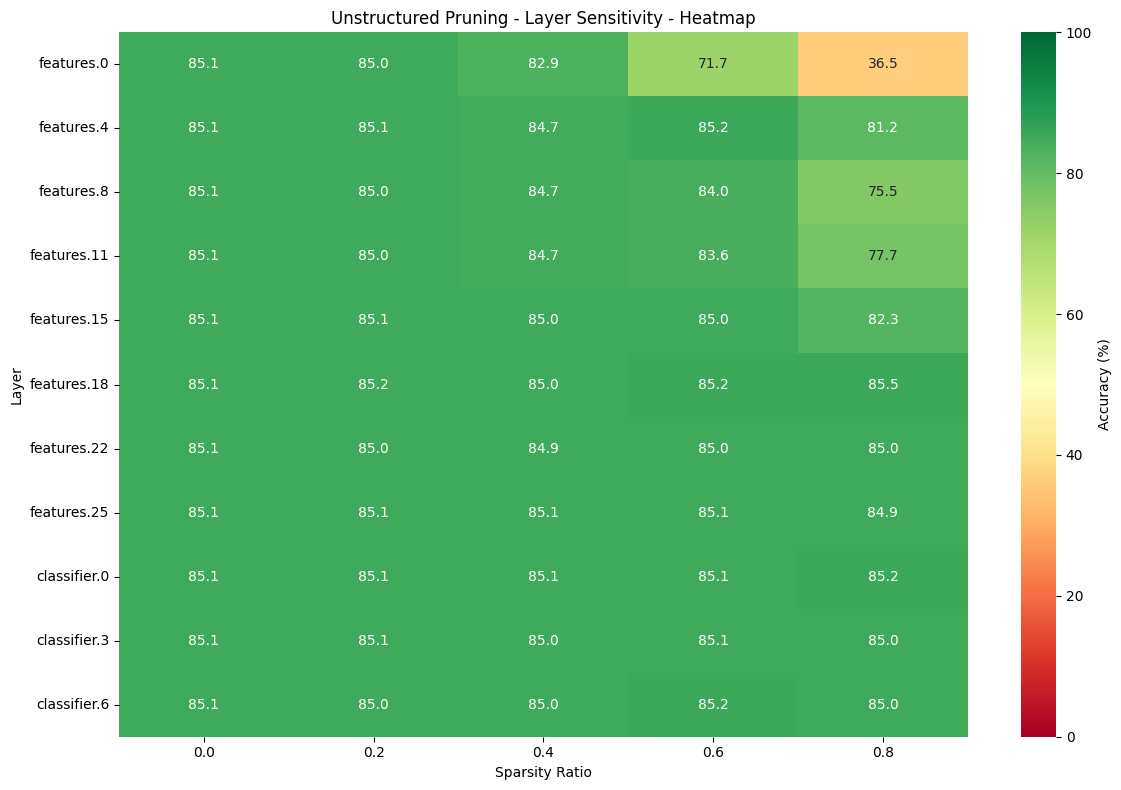


--- Part 1c: Applying Custom Sparsity Ratios ---
Custom sparsity ratios (targeting 70% overall):
  Conv layers: [0.1, 0.3, 0.5, 0.6, 0.65, 0.7, 0.75, 0.8]
  FC layers: [0.8, 0.8, 0.5]

Actual overall sparsity: 71.96%
Accuracy before fine-tuning: 83.84%


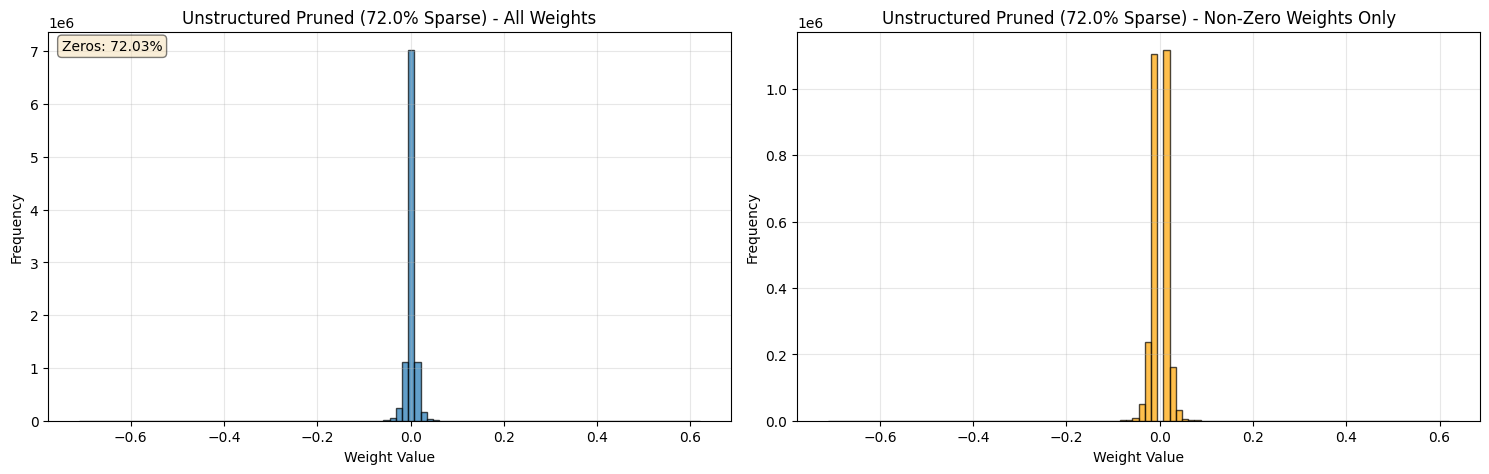

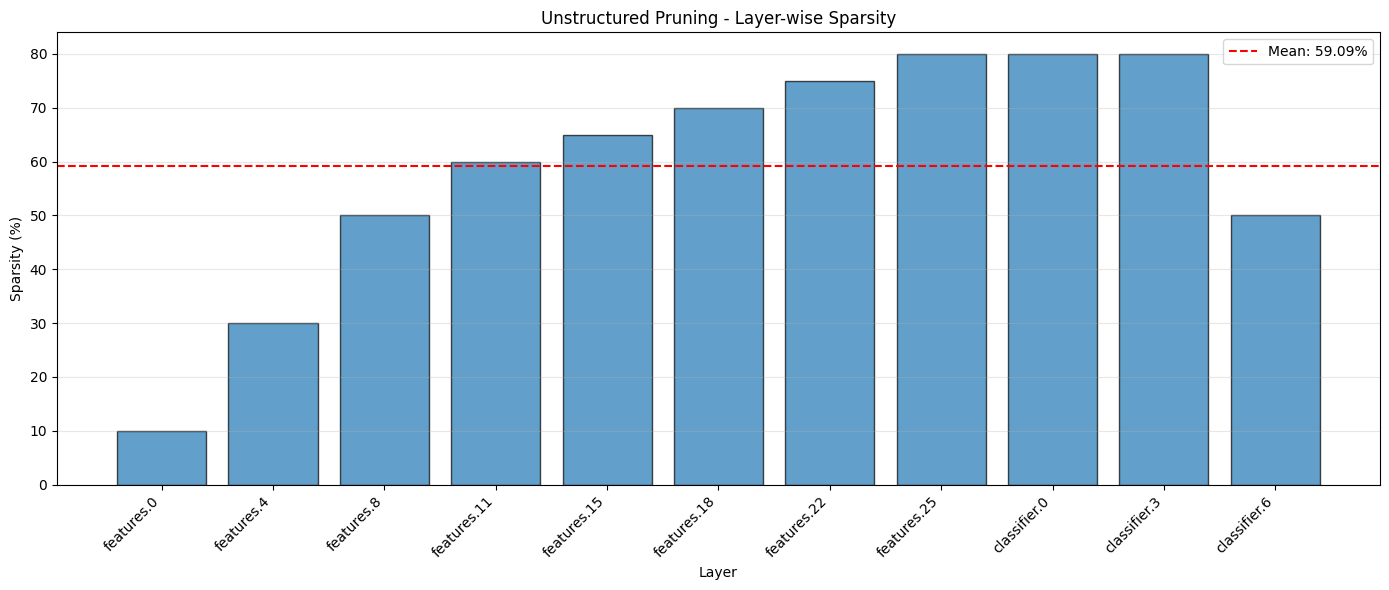


Fine-tuning unstructured pruned model...


Epoch 5/5: 100%|██████████| 391/391 [00:30<00:00, 12.69it/s, loss=0.172, acc=94.34%]


Accuracy after fine-tuning: 89.25%
Accuracy drop from baseline: -4.16%


In [ ]:
# TASK 1

print("TASK 1: UNSTRUCTURED PRUNING")

print("\n--- Part 1a: Weight Distribution Visualization ---")
plot_weight_distribution(model, "Baseline Model - Before Pruning")

print("\n--- Part 1b: Sensitivity Analysis ---")
sparsity_values = [0.0, 0.2, 0.4, 0.6, 0.8]

sensitivity_results_unstruct, sparsity_vals = sensitivity_analysis_unstructured(
    model, testloader, sparsity_values
)
plot_sensitivity_analysis(sensitivity_results_unstruct, sparsity_vals,
                         "Unstructured Pruning - Layer Sensitivity")

print("\n--- Part 1c: Applying Custom Sparsity Ratios ---")

custom_sparsity_unstructured = {
    'conv': [0.10, 0.30, 0.50, 0.60, 0.65, 0.70, 0.75, 0.80],  
    'fc': [0.80, 0.80, 0.50] 
}

print("Custom sparsity ratios (targeting 70% overall):")
print(f"  Conv layers: {custom_sparsity_unstructured['conv']}")
print(f"  FC layers: {custom_sparsity_unstructured['fc']}")

unstructured_pruned = apply_unstructured_pruning(model, custom_sparsity_unstructured)

actual_sparsity_unstruct = calculate_sparsity(unstructured_pruned)
print(f"\nActual overall sparsity: {actual_sparsity_unstruct*100:.2f}%")

acc_before_ft = evaluate_model(unstructured_pruned, testloader)
print(f"Accuracy before fine-tuning: {acc_before_ft:.2f}%")

plot_weight_distribution(unstructured_pruned,
                        f"Unstructured Pruned ({actual_sparsity_unstruct*100:.1f}% Sparse)")

plot_layer_sparsity(unstructured_pruned,
                    "Unstructured Pruning - Layer-wise Sparsity")

print("\nFine-tuning unstructured pruned model...")
acc_after_ft_unstruct = fine_tune_model(unstructured_pruned, trainloader,
                                        testloader, epochs=5, lr=0.001)
print(f"Accuracy after fine-tuning: {acc_after_ft_unstruct:.2f}%")
print(f"Accuracy drop from baseline: {baseline_accuracy - acc_after_ft_unstruct:.2f}%")


In [7]:
# Save model
torch.save(unstructured_pruned.state_dict(), 'vgg11_unstructured_pruned.pth')

TASK 2: STRUCTURED PRUNING

--- Part 2b: Sensitivity Analysis ---
Analyzing features.0...
  Sparsity 0.0: Accuracy 85.09%
  Sparsity 0.2: Accuracy 80.40%
  Sparsity 0.4: Accuracy 74.76%
  Sparsity 0.6: Accuracy 59.18%
Analyzing features.4...
  Sparsity 0.0: Accuracy 85.09%
  Sparsity 0.2: Accuracy 77.49%
  Sparsity 0.4: Accuracy 48.67%
  Sparsity 0.6: Accuracy 23.80%
Analyzing features.8...
  Sparsity 0.0: Accuracy 85.09%
  Sparsity 0.2: Accuracy 82.04%
  Sparsity 0.4: Accuracy 73.06%
  Sparsity 0.6: Accuracy 53.56%
Analyzing features.11...
  Sparsity 0.0: Accuracy 85.09%
  Sparsity 0.2: Accuracy 79.87%
  Sparsity 0.4: Accuracy 68.44%
  Sparsity 0.6: Accuracy 46.35%
Analyzing features.15...
  Sparsity 0.0: Accuracy 85.09%
  Sparsity 0.2: Accuracy 84.26%
  Sparsity 0.4: Accuracy 83.44%
  Sparsity 0.6: Accuracy 78.00%
Analyzing features.18...
  Sparsity 0.0: Accuracy 85.09%
  Sparsity 0.2: Accuracy 83.64%
  Sparsity 0.4: Accuracy 80.09%
  Sparsity 0.6: Accuracy 68.09%
Analyzing features.

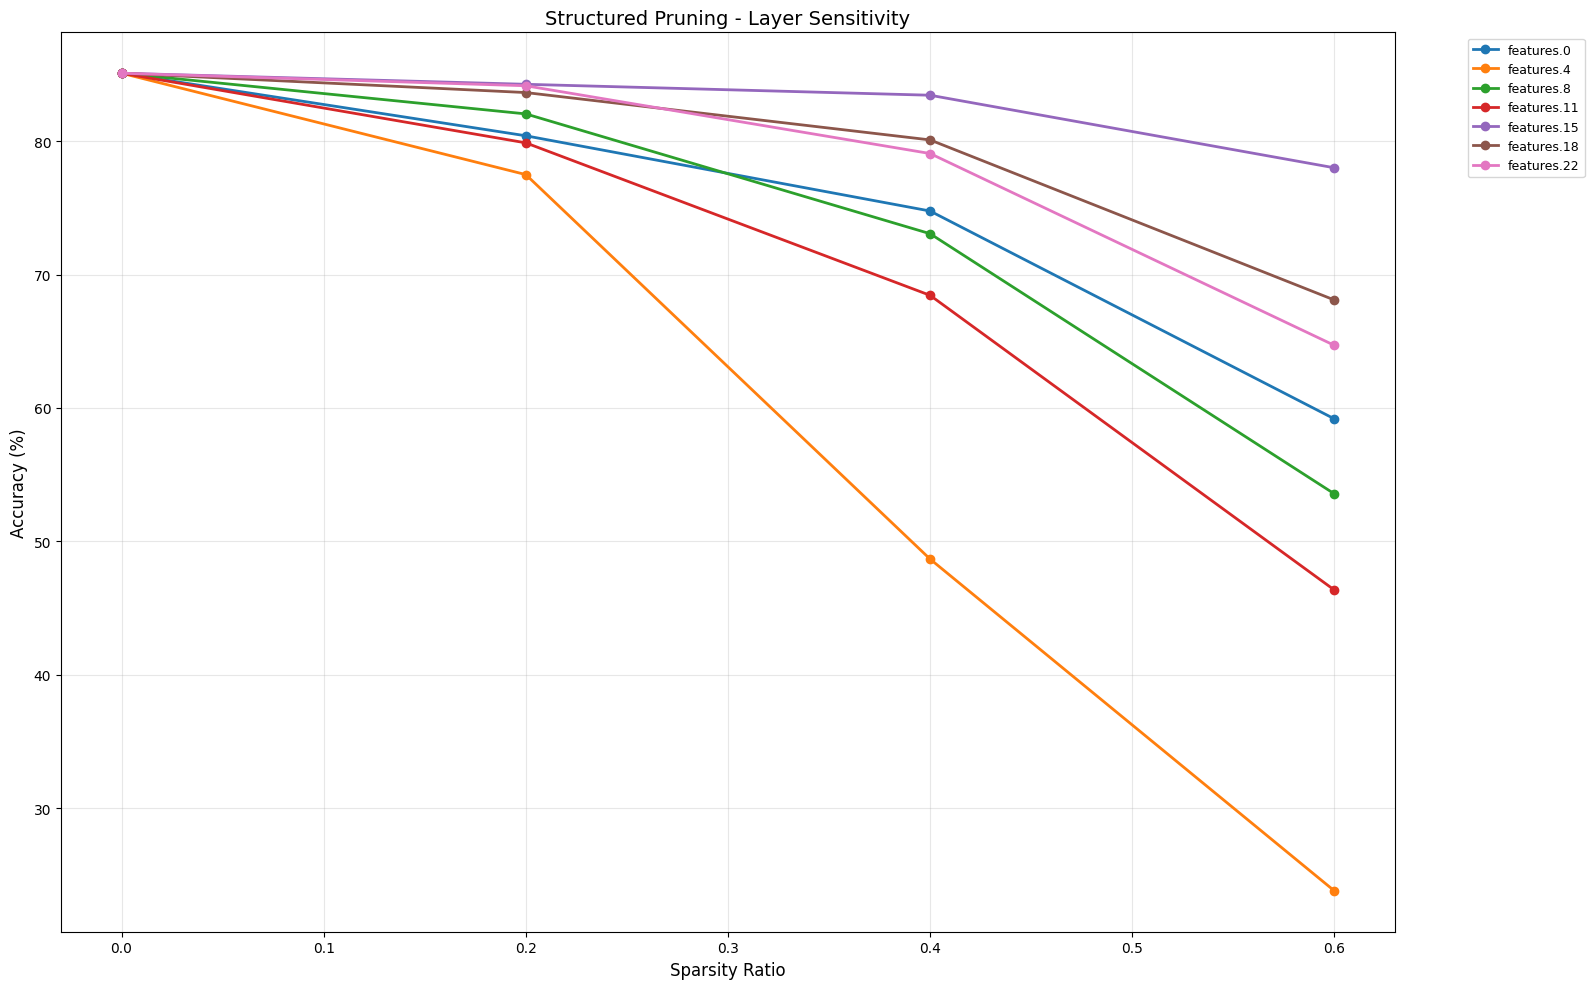

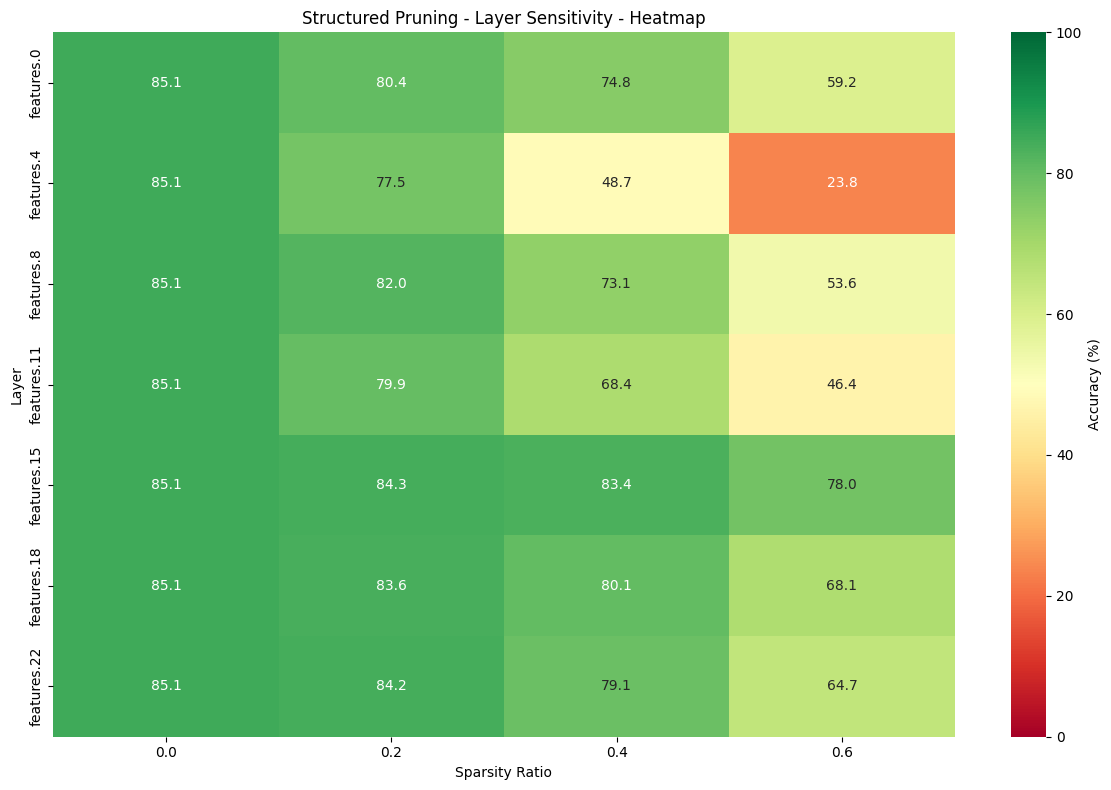


--- Part 2c: Applying Structured Pruning ---
Custom sparsity ratios for structured pruning:
  Conv layers: [0.1, 0.25, 0.4, 0.45, 0.5, 0.55, 0.7]

Structured pruning results:
  Parameter reduction: 71.45%
  Actual sparsity: 0.00%
  Parameters: 9,756,426 -> 2,785,206
  Accuracy before fine-tuning: 22.82%


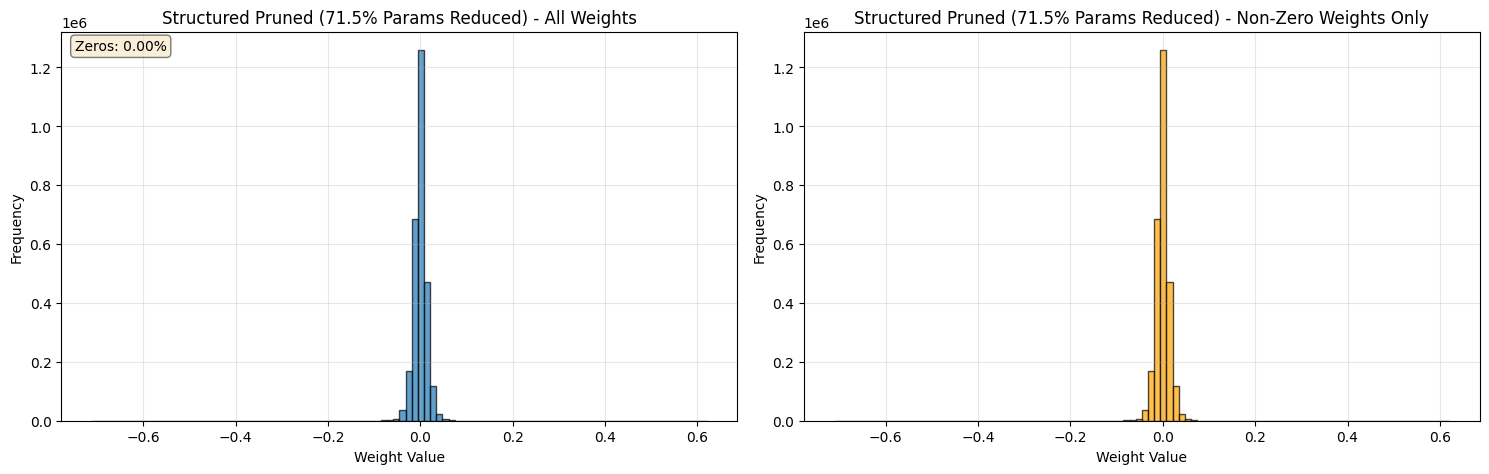

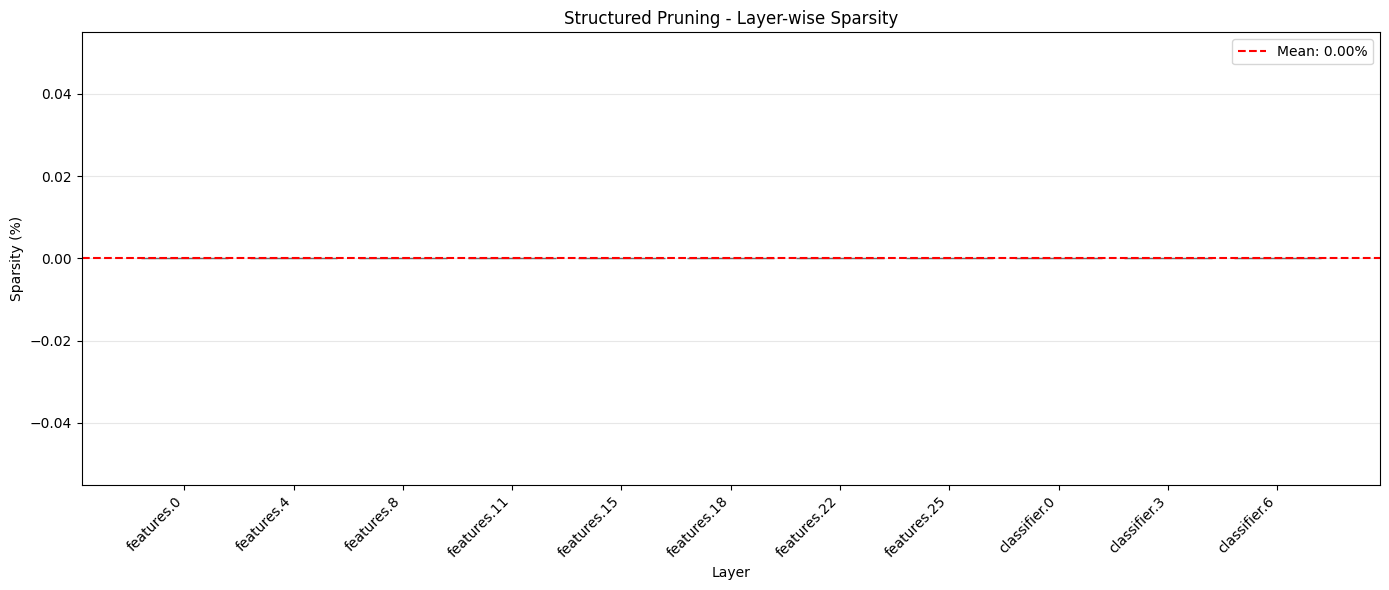


Fine-tuning structured pruned model...


Epoch 5/5: 100%|██████████| 391/391 [00:21<00:00, 18.29it/s, loss=0.247, acc=91.74%]


Accuracy after fine-tuning: 87.60%
Accuracy drop from baseline: -2.51%


In [ ]:
# TASK 2: STRUCTURED PRUNING

print("TASK 2: STRUCTURED PRUNING")

print("\n--- Part 2b: Sensitivity Analysis ---")

sensitivity_results_struct, sparsity_vals_struct = sensitivity_analysis_structured(
    model, testloader, sparsity_values=[0.0, 0.2, 0.4, 0.6]
)
plot_sensitivity_analysis(sensitivity_results_struct, sparsity_vals_struct,
                         "Structured Pruning - Layer Sensitivity")

print("\n--- Part 2c: Applying Structured Pruning ---")

custom_sparsity_structured = {
    'conv': [0.10, 0.25, 0.40, 0.45, 0.50, 0.55, 0.7],  
    'fc': [0.0, 0.0, 0.0] 
}

print("Custom sparsity ratios for structured pruning:")
print(f"  Conv layers: {custom_sparsity_structured['conv']}")

structured_pruned = apply_structured_pruning(model, custom_sparsity_structured)

actual_sparsity_struct = calculate_sparsity(structured_pruned)
structured_params = count_parameters(structured_pruned)
param_reduction = (1 - structured_params / baseline_params) * 100

print(f"\nStructured pruning results:")
print(f"  Parameter reduction: {param_reduction:.2f}%")
print(f"  Actual sparsity: {actual_sparsity_struct*100:.2f}%")
print(f"  Parameters: {baseline_params:,} -> {structured_params:,}")

acc_before_ft_struct = evaluate_model(structured_pruned, testloader)
print(f"  Accuracy before fine-tuning: {acc_before_ft_struct:.2f}%")

plot_weight_distribution(structured_pruned,
                        f"Structured Pruned ({param_reduction:.1f}% Params Reduced)")
plot_layer_sparsity(structured_pruned,
                    "Structured Pruning - Layer-wise Sparsity")

print("\nFine-tuning structured pruned model...")
acc_after_ft_struct = fine_tune_model(structured_pruned, trainloader,
                                      testloader, epochs=5, lr=0.001)
print(f"Accuracy after fine-tuning: {acc_after_ft_struct:.2f}%")
print(f"Accuracy drop from baseline: {baseline_accuracy - acc_after_ft_struct:.2f}%")


In [11]:
torch.save(structured_pruned.state_dict(), 'vgg11_structured_pruned.pth')

---

TASK 3: COMPARISON AND GRAD-CAM ANALYSIS

--- Part 3a: Grad-CAM Visualization ---


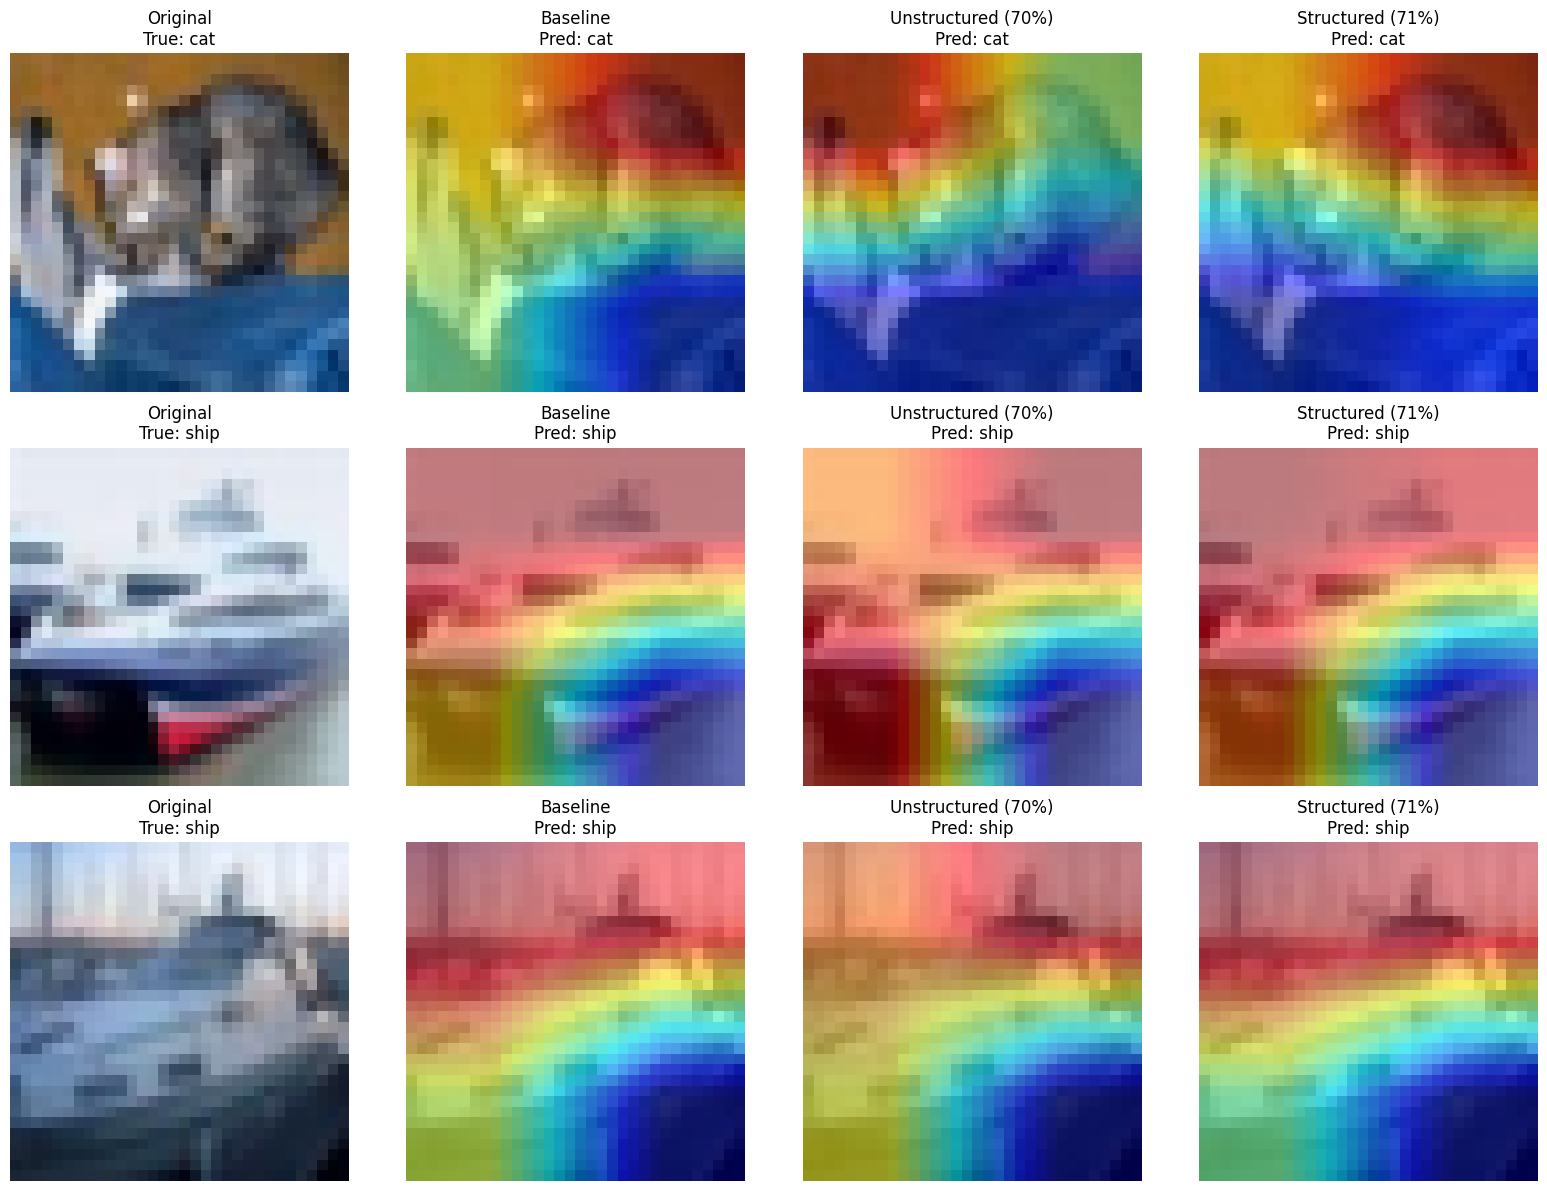


--- Part 3b & 3c: Comprehensive Model Comparison ---

Evaluating Baseline...

Evaluating Unstructured (70%)...

Evaluating Structured (71%)...


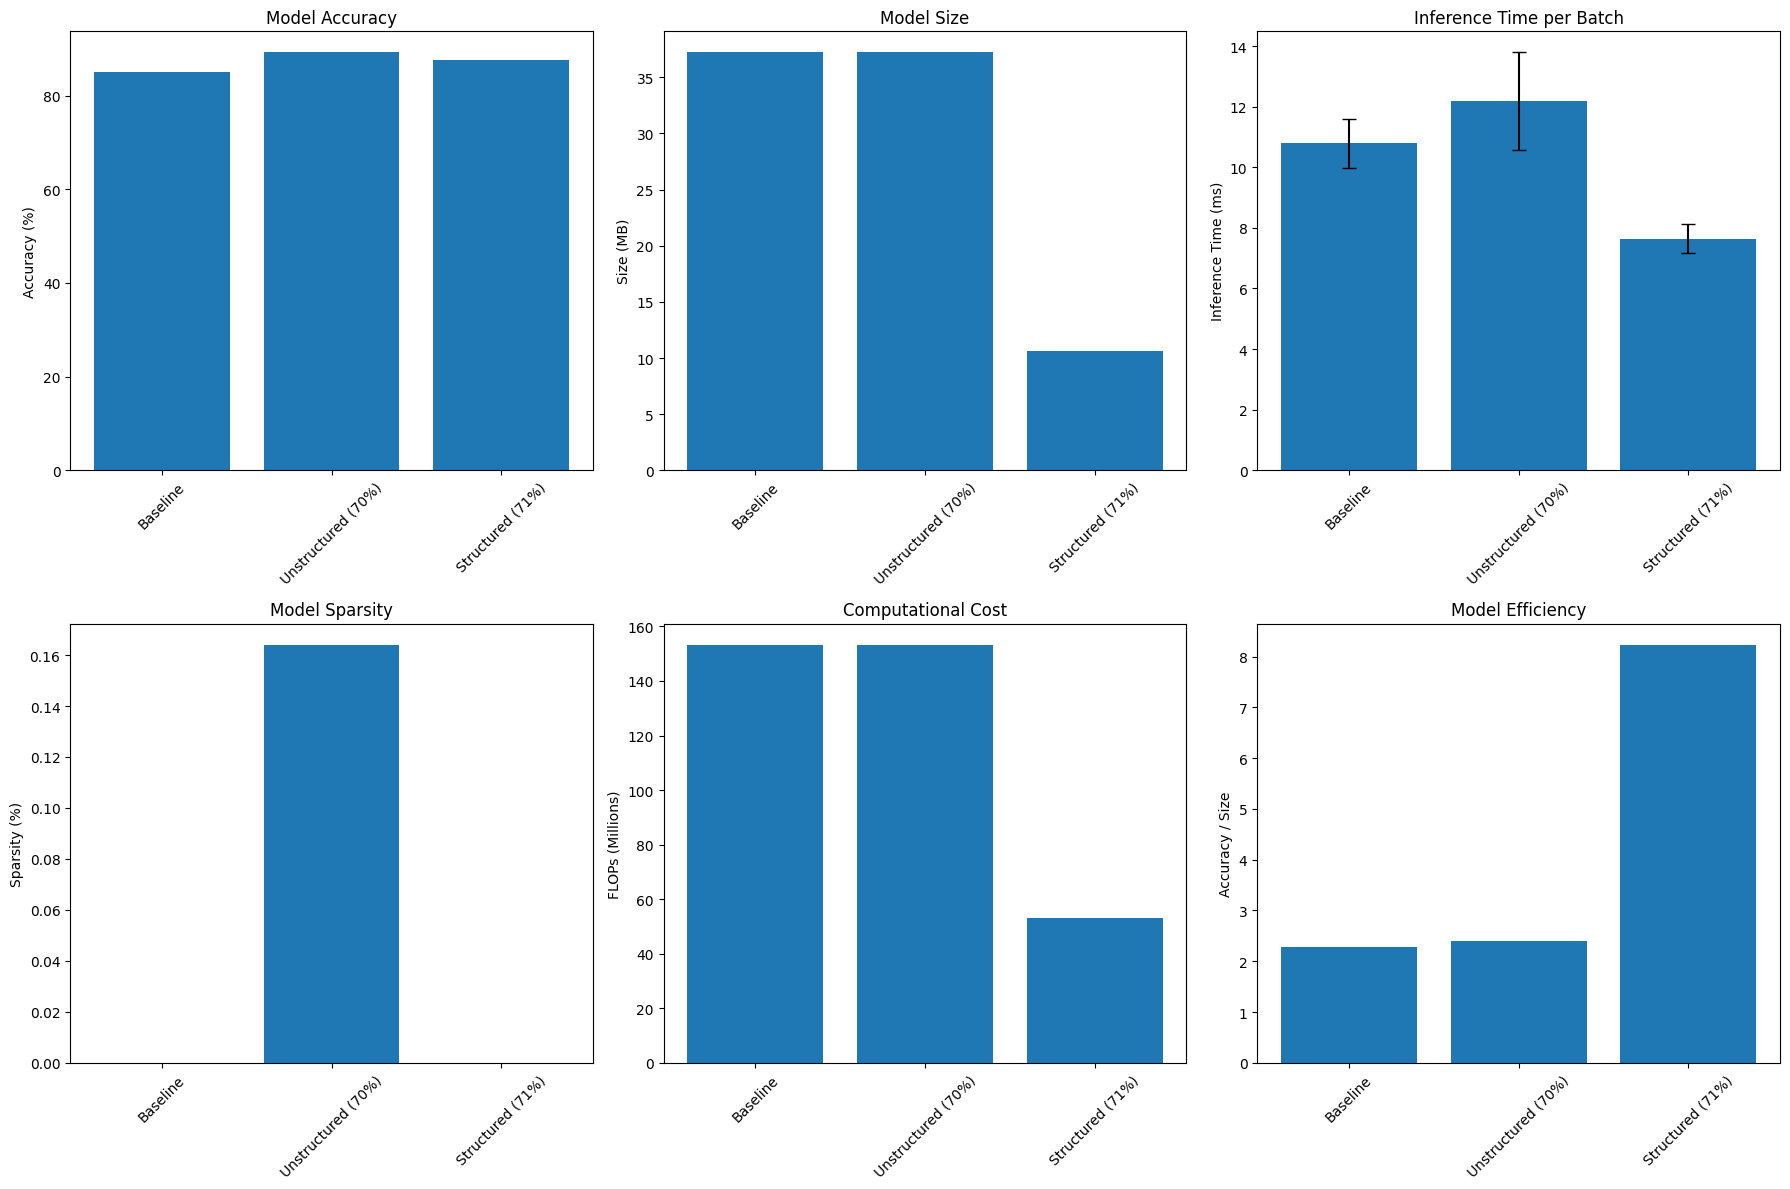


DETAILED COMPARISON TABLE

Baseline:
  Accuracy (%): 85.0900
  Total Params: 9756426
  Non-zero Params: 9756426
  Sparsity (%): 0.0000
  Size (MB): 37.2389
  Inference Time (ms): 10.7928
  Inference Std (ms): 0.8116
  FLOPs: 153293824
  FLOPs (M): 153.2938

Unstructured (70%):
  Accuracy (%): 89.2500
  Total Params: 9756426
  Non-zero Params: 9740421
  Sparsity (%): 0.1640
  Size (MB): 37.2389
  Inference Time (ms): 12.1856
  Inference Std (ms): 1.6128
  FLOPs: 153293824
  FLOPs (M): 153.2938

Structured (71%):
  Accuracy (%): 87.6000
  Total Params: 2785206
  Non-zero Params: 2785206
  Sparsity (%): 0.0000
  Size (MB): 10.6370
  Inference Time (ms): 7.6446
  Inference Std (ms): 0.4805
  FLOPs: 53237656
  FLOPs (M): 53.2377

--- Part 3d: Accuracy vs Sparsity Curves ---

Generating curve for UNSTRUCTURED pruning...

Testing sparsity level: 0.0
  Accuracy before fine-tuning: 85.09%


Epoch 3/3: 100%|██████████| 391/391 [00:21<00:00, 18.02it/s, loss=0.178, acc=94.09%]


  Accuracy after fine-tuning: 89.13%
  Actual sparsity: 0.00%

Testing sparsity level: 0.2
  Accuracy before fine-tuning: 85.25%


Epoch 3/3: 100%|██████████| 391/391 [00:20<00:00, 19.01it/s, loss=0.180, acc=93.92%]


  Accuracy after fine-tuning: 89.18%
  Actual sparsity: 19.98%

Testing sparsity level: 0.4
  Accuracy before fine-tuning: 81.84%


Epoch 3/3: 100%|██████████| 391/391 [00:20<00:00, 18.98it/s, loss=0.186, acc=93.86%]


  Accuracy after fine-tuning: 89.40%
  Actual sparsity: 39.96%

Testing sparsity level: 0.6
  Accuracy before fine-tuning: 64.96%


Epoch 3/3: 100%|██████████| 391/391 [00:21<00:00, 18.44it/s, loss=0.197, acc=93.55%]


  Accuracy after fine-tuning: 88.99%
  Actual sparsity: 59.94%

Testing sparsity level: 0.8
  Accuracy before fine-tuning: 25.99%


Epoch 3/3: 100%|██████████| 391/391 [00:21<00:00, 18.29it/s, loss=0.252, acc=91.78%]


  Accuracy after fine-tuning: 88.21%
  Actual sparsity: 79.92%


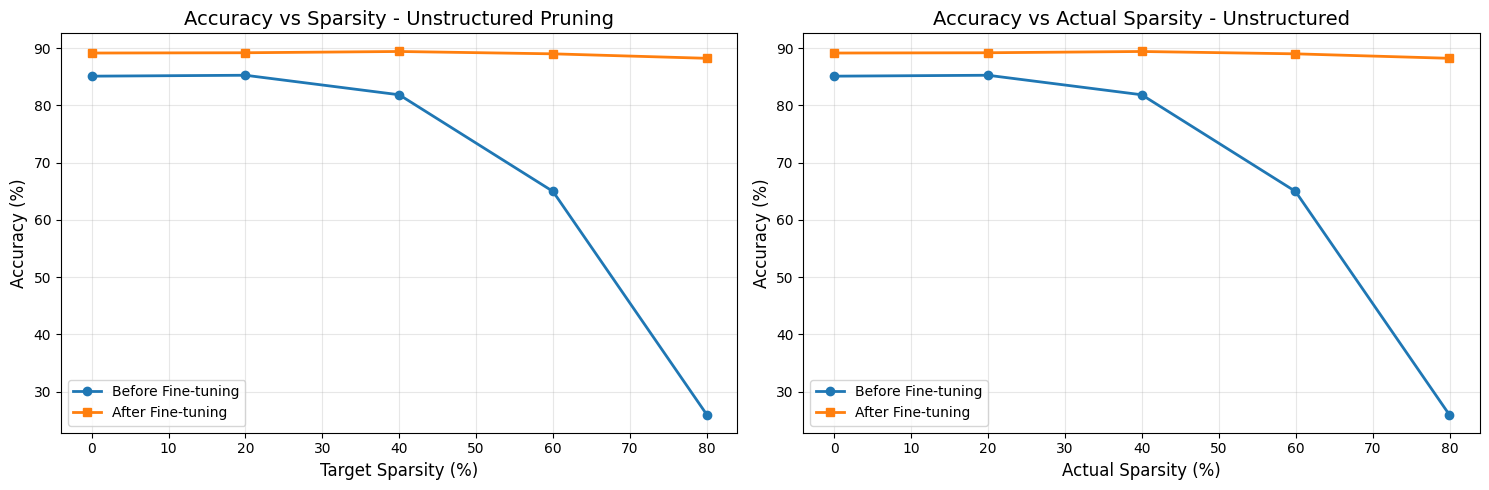


Generating curve for STRUCTURED pruning...

Testing sparsity level: 0.0
  Accuracy before fine-tuning: 85.09%


Epoch 3/3: 100%|██████████| 391/391 [00:21<00:00, 18.25it/s, loss=0.175, acc=94.13%]


  Accuracy after fine-tuning: 89.34%
  Actual sparsity: 0.00%

Testing sparsity level: 0.2
  Accuracy before fine-tuning: 47.34%


Epoch 3/3: 100%|██████████| 391/391 [00:22<00:00, 17.08it/s, loss=0.221, acc=92.64%]


  Accuracy after fine-tuning: 88.79%
  Actual sparsity: 0.00%

Testing sparsity level: 0.4
  Accuracy before fine-tuning: 23.75%


Epoch 3/3: 100%|██████████| 391/391 [00:21<00:00, 18.22it/s, loss=0.286, acc=90.37%]


  Accuracy after fine-tuning: 87.33%
  Actual sparsity: 0.00%

Testing sparsity level: 0.6
  Accuracy before fine-tuning: 11.79%


Epoch 3/3: 100%|██████████| 391/391 [00:19<00:00, 19.61it/s, loss=0.415, acc=86.09%]


  Accuracy after fine-tuning: 84.01%
  Actual sparsity: 0.00%

Testing sparsity level: 0.8
  Accuracy before fine-tuning: 10.00%


Epoch 3/3: 100%|██████████| 391/391 [00:19<00:00, 19.98it/s, loss=0.736, acc=75.06%]


  Accuracy after fine-tuning: 75.55%
  Actual sparsity: 0.00%


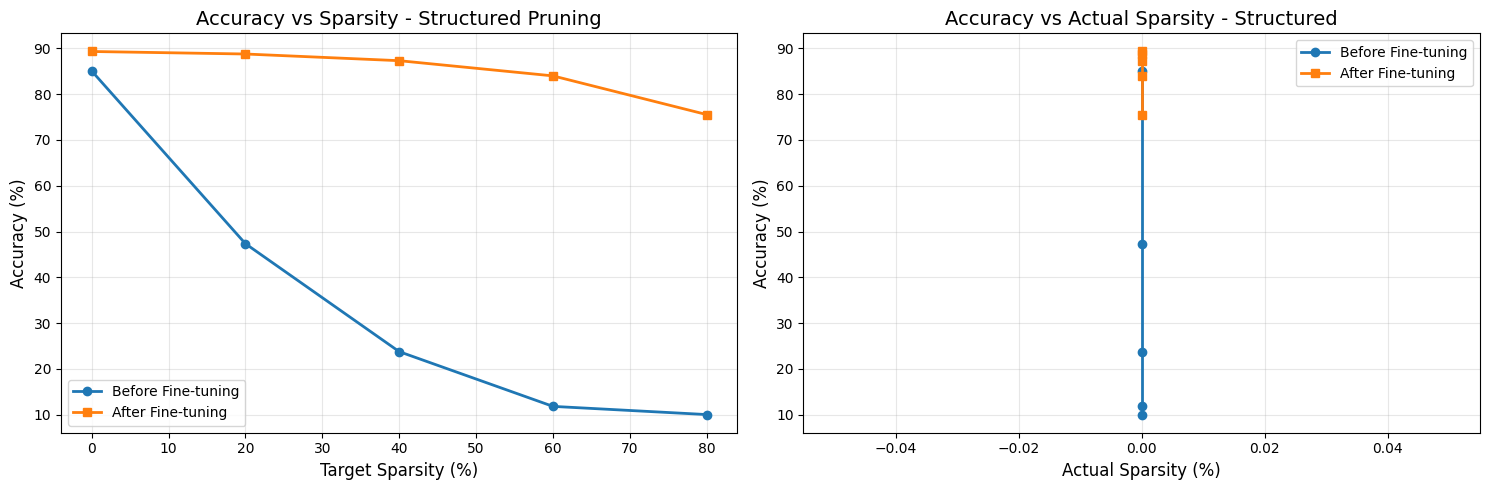

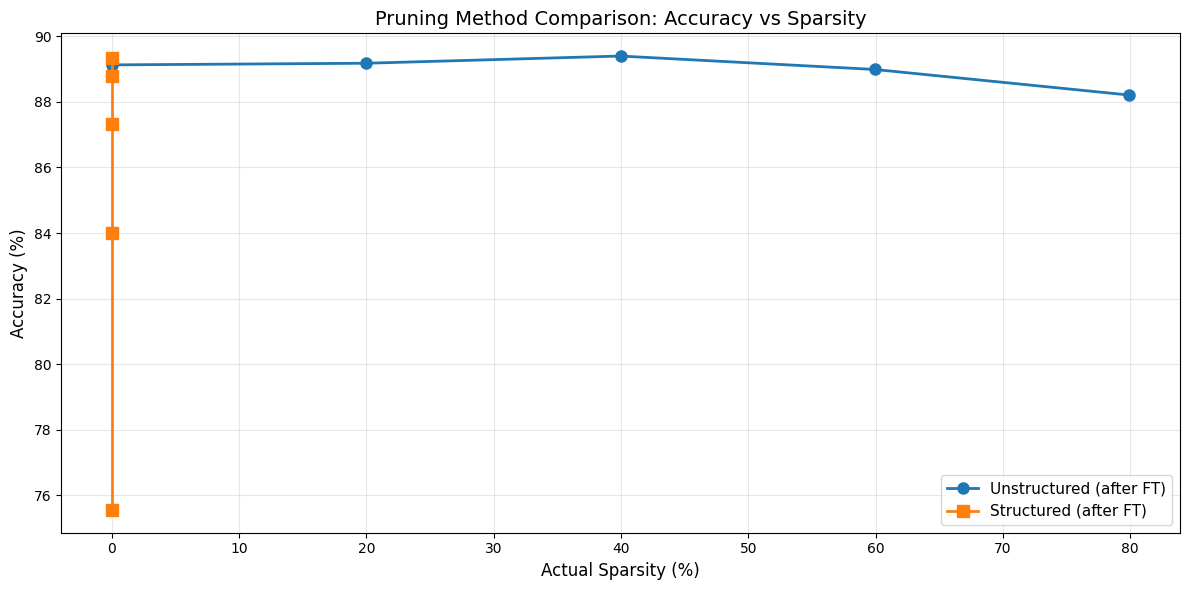

In [ ]:
print("TASK 3: COMPARISON AND GRAD-CAM ANALYSIS")

print("\n--- Part 3a: Grad-CAM Visualization ---")
models_to_compare = [model, unstructured_pruned, structured_pruned]
model_names = ['Baseline', 'Unstructured (70%)', f'Structured ({param_reduction:.0f}%)']

generate_gradcam_comparison(models_to_compare, model_names, testloader, num_samples=3)

print("\n--- Part 3b & 3c: Comprehensive Model Comparison ---")
comparison_results = compare_models_comprehensive(models_to_compare,
                                                  model_names, testloader)

print("\n" + "="*80)
print("DETAILED COMPARISON TABLE")
print("="*80)
for result in comparison_results:
    print(f"\n{result['Model']}:")
    for key, value in result.items():
        if key != 'Model':
            if isinstance(value, float):
                print(f"  {key}: {value:.4f}")
            else:
                print(f"  {key}: {value}")

print("\n--- Part 3d: Accuracy vs Sparsity Curves ---")

print("\nGenerating curve for UNSTRUCTURED pruning...")
acc_before_u, acc_after_u, sparsity_u = accuracy_vs_sparsity_curve(
    model, trainloader, testloader,
    sparsity_levels=[0.0, 0.2, 0.4, 0.6, 0.8],
    pruning_type='unstructured'
)

print("\nGenerating curve for STRUCTURED pruning...")
acc_before_s, acc_after_s, sparsity_s = accuracy_vs_sparsity_curve(
    model, trainloader, testloader,
    sparsity_levels=[0.0, 0.2, 0.4, 0.6, 0.8],
    pruning_type='structured'
)

plt.figure(figsize=(12, 6))
plt.plot(sparsity_u, acc_after_u, 'o-', label='Unstructured (after FT)',
          linewidth=2, markersize=8)
plt.plot(sparsity_s, acc_after_s, 's-', label='Structured (after FT)',
          linewidth=2, markersize=8)
plt.xlabel('Actual Sparsity (%)', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.title('Pruning Method Comparison: Accuracy vs Sparsity', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
print("ADDITIONAL ANALYSIS: ROBUSTNESS TESTING")

print("\nTesting extreme sparsity levels to find collapse points...")

extreme_sparsities = [0.85, 0.90, 0.93, 0.95, 0.97]

print("\n1. UNSTRUCTURED PRUNING at extreme sparsities:")
for sparsity in extreme_sparsities:
    num_conv = len(get_conv_layers(model))
    num_fc = len(get_fc_layers(model))
    config = {'conv': [sparsity] * num_conv, 'fc': [sparsity] * num_fc}

    pruned_extreme = apply_unstructured_pruning(model, config)
    acc = evaluate_model(pruned_extreme, testloader)
    actual_sp = calculate_sparsity(pruned_extreme) * 100

    print(f"  Target: {sparsity*100:.0f}% | Actual: {actual_sp:.1f}% | Acc: {acc:.2f}%")

    if acc < 20:
        print(f"  >>> COLLAPSE at ~{sparsity*100:.0f}% sparsity!")
        break

print("\n2. STRUCTURED PRUNING at extreme sparsities:")
for sparsity in [0.70, 0.75, 0.80, 0.85]:
    num_conv = len(get_conv_layers(model))
    config = {'conv': [sparsity] * (num_conv-1), 'fc': [0.0] * 3}

    try:
        pruned_extreme = apply_structured_pruning(model, config)
        acc = evaluate_model(pruned_extreme, testloader)
        params_left = count_parameters(pruned_extreme)
        reduction = (1 - params_left/baseline_params) * 100

        print(f"  Target: {sparsity*100:.0f}% | Params reduced: {reduction:.1f}% | Acc: {acc:.2f}%")

        if acc < 20:
            print(f"  >>> COLLAPSE at ~{sparsity*100:.0f}% channel pruning!")
            break
    except Exception as e:
        print(f"  Target: {sparsity*100:.0f}% | FAILED: {str(e)[:50]}")
        print(f"  >>> Cannot prune further (structural constraints)")
        break

print("\n" + "="*80)


# Final summary
print("\nFINAL SUMMARY:")
print(f"Baseline: {baseline_accuracy:.2f}% | {baseline_size:.2f} MB")
print(f"Unstructured (70% sparse): {acc_after_ft_unstruct:.2f}% | "
      f"{get_model_size(unstructured_pruned):.2f} MB | "
      f"Drop: {baseline_accuracy - acc_after_ft_unstruct:.2f}%")
print(f"Structured ({param_reduction:.0f}% reduced): {acc_after_ft_struct:.2f}% | "
      f"{get_model_size(structured_pruned):.2f} MB | "
      f"Drop: {baseline_accuracy - acc_after_ft_struct:.2f}%")


ADDITIONAL ANALYSIS: ROBUSTNESS TESTING

Testing extreme sparsity levels to find collapse points...

1. UNSTRUCTURED PRUNING at extreme sparsities:
  Target: 85% | Actual: 84.9% | Acc: 11.25%
  >>> COLLAPSE at ~85% sparsity!

2. STRUCTURED PRUNING at extreme sparsities:
  Target: 70% | Params reduced: 81.0% | Acc: 10.00%
  >>> COLLAPSE at ~70% channel pruning!


FINAL SUMMARY:
Baseline: 85.09% | 37.24 MB
Unstructured (70% sparse): 89.25% | 37.24 MB | Drop: -4.16%
Structured (71% reduced): 87.60% | 10.64 MB | Drop: -2.51%
